In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
from scipy.optimize import newton


plt.rcParams['path.simplify'] = False
# Menonaktifkan pembagian garis menjadi "chunks" kecil
plt.rcParams['agg.path.chunksize'] = 0


print("Library berhasil diimpor.")
print("Tahap 1: Definisi Konstanta & Kondisi Awal (3D)")

G = 6.674e-11 # Nm^2/kg^2
M_BUMI = 5.972e24 # kg
M_BULAN = 7.348e22 # kg
R_BUMI = 6.371e6 # meter (Radius Bumi)
R_BULAN = 1.737e6 # meter (Radius Bulan)

# Kondisi Awal Bulan (3D)
r_awal_x = 3.844e8 # Posisi awal sumbu x
r_awal_y = 0 # Posisi awal sumbu y
r_awal_z = 0 # Posisi awal sumbu z (agar ada variasi di z)

# Kecepatan awal x
v_awal_x = 0
v_awal_y = 1022 # Kecepatan awal y (tangensial)
v_awal_z = 0 # Kecepatan awal z (untuk membuat geraknya menjadi 3D)

# State vector awal: S = [x, y, z, vx, vy, vz]
S0 = [r_awal_x, r_awal_y, r_awal_z, v_awal_x, v_awal_y, v_awal_z]

# Waktu simulasi
t_awal = 0
t_akhir = 3600 * 24 * 28 # (Bisa disesuaikan sesuai kebutuhan)
dt = 180 # Delta t dalam detik (Bisa disesuaikan untuk titik di animasi)
t_eval = np.arange(t_awal, t_akhir, dt)

print(f"Kondisi awal Bulan (3D): Posisi ({S0[0]/1000:.0f}) km, ({S0[1]/1000:.0f}) km, ({S0[2]/1000:.0f}) km, Kec. ({S0[3]:.0f}) m/s, ({S0[4]:.0f}) m/s, ({S0[5]:.0f}) m/s")

Library berhasil diimpor.
Tahap 1: Definisi Konstanta & Kondisi Awal (3D)
Kondisi awal Bulan (3D): Posisi (384400) km, (0) km, (0) km, Kec. (0) m/s, (1022) m/s, (0) m/s


In [17]:
# Model Matematis (Tahap 2)

print("\nTahap 2: Model Matematis (Fungsi PDB 3D)")

def sistem_pdb_3d(t, S):
    x, y, z, vx, vy, vz = S
    # Jarak dari pusat Bumi ke Bulan
    jarak_satelit_ke_pusat = np.sqrt(x**2 + y**2 + z**2)
    if jarak_satelit_ke_pusat == 0:
        return [0,0,0,0,0,0]

    r_kubik = jarak_satelit_ke_pusat**3

    dxdt = vx
    dydt = vy
    dzdt = vz
    dvxdt = -G * M_BUMI * x / r_kubik
    dvydt = -G * M_BUMI * y / r_kubik
    dvzdt = -G * M_BUMI * z / r_kubik

    return [dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt]

print("Fungsi sistem_pdb_3d didefinisikan.")


Tahap 2: Model Matematis (Fungsi PDB 3D)
Fungsi sistem_pdb_3d didefinisikan.


In [18]:
# Menyelesaikan PDB (Tahap 3.A)

print("\nTahap 3.A: Menyelesaikan PDB dengan Runge-Kutta (solve_ivp)")
sol = solve_ivp(sistem_pdb_3d, [t_awal, t_akhir], S0, t_eval=t_eval, method='RK45', dense_output=True)

t = sol.t
x_bulan = sol.y[0,:]
y_bulan = sol.y[1,:]
z_bulan = sol.y[2,:]

print(f"Simulasi PDB selesai. Jumlah titik data: {len(t)}")


Tahap 3.A: Menyelesaikan PDB dengan Runge-Kutta (solve_ivp)
Simulasi PDB selesai. Jumlah titik data: 13440


In [19]:
# Interpolasi & Newton-Raphson (Tahap 3.B & 3.C)

print("\nTahap 3.B: Interpolasi Hasil PDB (Untuk Jarak)")
jarak_tumbukan_ideal = R_BUMI + R_BULAN
t_tumbukan_nr = None # Diinisialisasi
interp_jarak_3d = None # Inisialisasi interp_jarak_3d di sini
unique_t = np.array([]) # Inisialisasi unique_t untuk menghindari NameError jika interpolasi gagal

if len(t) > 3: # Ini untuk menghitung beberapa poin untuk interpolasi yang baik
    jarak_bulan_bumi_3d = np.sqrt(x_bulan**2 + y_bulan**2 + z_bulan**2)

    if np.any(np.isnan(jarak_bulan_bumi_3d)):
        print("PERINGATAN: Ada nilai NaN di jarak_bulan_bumi_3d. Ini bisa menyebabkan masalah interpolasi.")
        print("Melewati interpolasi karena ada NaN di data jarak.")
    else:
        unique_t, unique_indices = np.unique(t, return_index=True)

        if len(unique_t) > 3:
            try:
                interp_jarak_3d = CubicSpline(unique_t, jarak_bulan_bumi_3d[unique_indices], extrapolate=False)
                print("Interpolasi jarak (3D) berhasil dibuat.")

                print("\nTahap 3.C: Mencari Waktu Tumbukan dengan Newton-Raphson (3D)")
                def fungsi_tumbukan_3d(waktu_cek):
                    if waktu_cek < unique_t[0] or waktu_cek > unique_t[-1]:
                        return 1e12
                    interpolated_val = interp_jarak_3d(waktu_cek)
                    if np.isnan(interpolated_val):
                        return 1e12
                    return interpolated_val - jarak_tumbukan_ideal

                indeks_mendekati_tumbukan = np.where(jarak_bulan_bumi_3d <= jarak_tumbukan_ideal)[0]

                if len(indeks_mendekati_tumbukan) > 0:
                    t_tebakan_awal = t[indeks_mendekati_tumbukan[0]]
                    try:
                        if t_tebakan_awal < unique_t[0]: t_tebakan_awal = unique_t[0]
                        if t_tebakan_awal > unique_t[-1]: t_tebakan_awal = unique_t[-1]

                        t_tumbukan_nr = newton(fungsi_tumbukan_3d, x0=t_tebakan_awal)

                        if t_tumbukan_nr < unique_t[0] or t_tumbukan_nr > unique_t[-1]:
                            print(f"Newton-Raphson menemukan solusi {t_tumbukan_nr/3600:.2f} jam di luar rentang interpolasi. Tidak dapat memplot titik tumbukan.")
                            t_tumbukan_nr = None
                        else:
                            print(f"Estimasi waktu tumbukan (NR): {t_tumbukan_nr/3600:.2f} jam")
                            pos_tumbukan_xyz = sol.sol(t_tumbukan_nr)[:3]
                            jarak_saat_nr = np.linalg.norm(pos_tumbukan_xyz)
                            print(f"Jarak pada waktu tsb (Interpolasi PDB): {jarak_saat_nr/1000:.2f} km")
                            print(f"Target jarak tumbukan: {jarak_tumbukan_ideal/1000:.2f} km")

                    except RuntimeError as e:
                        print(f"Newton-Raphson gagal konvergen: {e}. Coba tebakan awal atau parameter lain.")
                        t_tumbukan_nr = None
                    except ValueError as e:
                        print(f"Error pada Newton-Raphson: {e}.")
                        t_tumbukan_nr = None
                else:
                    print("Bulan tidak menumbuk Bumi dalam rentang waktu simulasi.")
                    idx_min_jarak = np.argmin(jarak_bulan_bumi_3d)
                    print(f"Jarak terdekat: {jarak_bulan_bumi_3d[idx_min_jarak]/1000:.2f} km (pada t={t[idx_min_jarak]/3600:.2f} jam)")
                    print(f"Target jarak tumbukan: {jarak_tumbukan_ideal/1000:.2f} km")
            except ValueError as e:
                print(f"ERROR: Gagal membuat CubicSpline: {e}. Pastikan data unique_t dan jarak_bulan_bumi_3d valid.")
                interp_jarak_3d = None
        else:
            print("Data waktu tidak valid/cukup untuk CubicSpline (kurang dari 4 titik unik). Lewati interpolasi & Newton-Raphson.")
else:
    print("Tidak cukup data untuk interpolasi dan Newton-Raphson.")

print("Tahap interpolasi dan Newton-Raphson selesai.")


Tahap 3.B: Interpolasi Hasil PDB (Untuk Jarak)


Interpolasi jarak (3D) berhasil dibuat.

Tahap 3.C: Mencari Waktu Tumbukan dengan Newton-Raphson (3D)
Bulan tidak menumbuk Bumi dalam rentang waktu simulasi.
Jarak terdekat: 357241.64 km (pada t=671.95 jam)
Target jarak tumbukan: 8108.00 km
Tahap interpolasi dan Newton-Raphson selesai.



Tahap 4: Visualisasi Hasil (3D)
Plot statis 3D ditampilkan. Tutup untuk melanjutkan ke plot jarak & animasi.


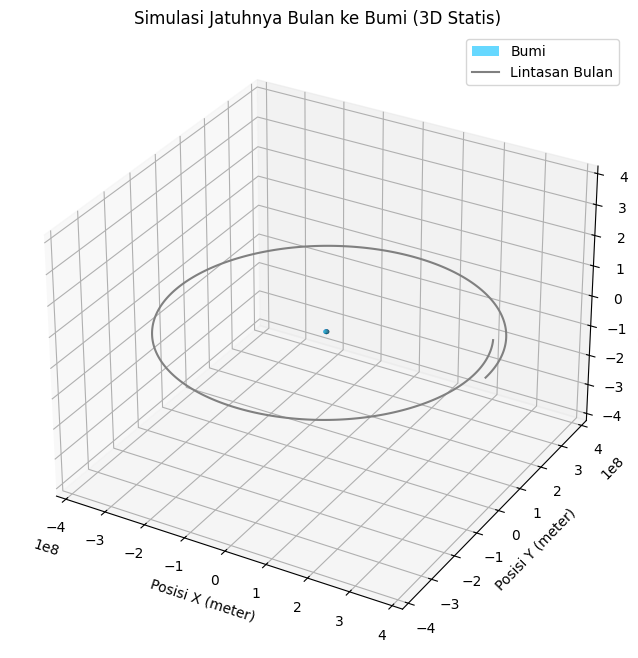

In [21]:
# Plot Statis 3D (Tahap 4)

print("\nTahap 4: Visualisasi Hasil (3D)")

# --- Plot Statis 3D
fig_static_3d = plt.figure(figsize=(10, 8))
ax_static_3d = fig_static_3d.add_subplot(111, projection='3d')

# Plot Bumi sebagai bola (permukaan)
u_earth = np.linspace(0, 2 * np.pi, 100)
v_earth = np.linspace(0, np.pi, 100)
x_earth_surf = R_BUMI * np.outer(np.cos(u_earth), np.sin(v_earth))
y_earth_surf = R_BUMI * np.outer(np.sin(u_earth), np.sin(v_earth))
z_earth_surf = R_BUMI * np.outer(np.ones(np.size(u_earth)), np.cos(v_earth))
ax_static_3d.plot_surface(x_earth_surf, y_earth_surf, z_earth_surf, color='deepskyblue', alpha=0.6, label='Bumi')

# Plot lintasan Bulan
ax_static_3d.plot(x_bulan, y_bulan, z_bulan, label='Lintasan Bulan (RK4)', color='grey')

# Plot titik tumbukan jika ditemukan dan valid
if t_tumbukan_nr is not None and t_tumbukan_nr >= t_awal and t_tumbukan_nr <= t_akhir:
    try:
        pos_tumbukan_xyz_plot = sol.sol(t_tumbukan_nr)[:3]
        ax_static_3d.scatter(pos_tumbukan_xyz_plot[0], pos_tumbukan_xyz_plot[1], pos_tumbukan_xyz_plot[2],
                             color='red', s=100, label=f"Tumbukan (NR) t={t_tumbukan_nr/3600:.2f} jam", depthshade=False)
    except Exception as e:
        print(f"Tidak bisa plot titik tumbukan: {e}")

# Pengaturan Axes untuk plot statis 3D
max_range = np.max(np.abs(np.concatenate((x_bulan, y_bulan, z_bulan)))) * 1.1
ax_static_3d.set_xlim([-max_range, max_range])
ax_static_3d.set_ylim([-max_range, max_range])
ax_static_3d.set_zlim([-max_range, max_range])
ax_static_3d.set_xlabel("Posisi X (meter)")
ax_static_3d.set_ylabel("Posisi Y (meter)")
ax_static_3d.set_zlabel("Posisi Z (meter)")
ax_static_3d.set_title("Simulasi Jatuhnya Bulan ke Bumi (3D Statis)")
bumi_proxy = plt.Rectangle((0, 0), 1, 1, fc="deepskyblue", alpha=0.6)
ax_static_3d.legend([bumi_proxy, ax_static_3d.get_lines()[0]], ['Bumi', 'Lintasan Bulan'])
print("Plot statis 3D ditampilkan. Tutup untuk melanjutkan ke plot jarak & animasi.")
plt.show() # Ini akan memblokir eksekusi sampai Anda menutup jendela

Plot jarak vs waktu akan ditampilkan. Tutup untuk melanjutkan ke animasi 3D.


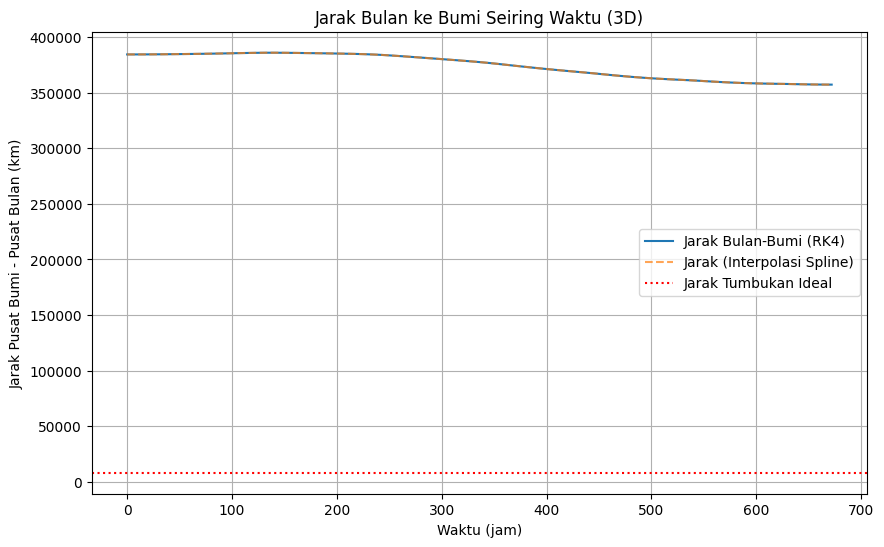

In [22]:
# --- Plot Jarak vs Waktu ---
if 'jarak_bulan_bumi_3d' in locals() and len(t) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(t / 3600, jarak_bulan_bumi_3d / 1000, label='Jarak Bulan-Bumi (RK4)')

    if interp_jarak_3d is not None and len(unique_t) > 1:
        t_halus = np.linspace(unique_t[0], unique_t[-1], 500)
        interp_values = interp_jarak_3d(t_halus)

        valid_indices = ~np.isnan(interp_values)

        if np.any(valid_indices):
            plt.plot(t_halus[valid_indices] / 3600,
                     interp_values[valid_indices] / 1000,
                     linestyle='--', # Perbaikan untuk ValueError: '---'
                     label='Jarak (Interpolasi Spline)',
                     alpha=0.7)
        else:
            print("Peringatan: Interpolasi spline menghasilkan semua NaN, tidak diplot pada grafik jarak.")
    else:
        print("Peringatan: interpolator tidak tersedia atau unique_t tidak memiliki cukup titik untuk plot interpolasi.")

    plt.axhline(jarak_tumbukan_ideal / 1000, color='red', linestyle=':', label='Jarak Tumbukan Ideal')
    if t_tumbukan_nr is not None and t_tumbukan_nr >= t_awal and t_tumbukan_nr <= t_akhir:
        if interp_jarak_3d is not None and t_tumbukan_nr >= unique_t[0] and t_tumbukan_nr <= unique_t[-1]:
            plt.plot(t_tumbukan_nr / 3600, interp_jarak_3d(t_tumbukan_nr) / 1000, 'ro', label='Titik Tumbukan (NR)')
        else:
            print("Peringatan: Titik tumbukan NR tidak diplot pada grafik jarak karena interpolator tidak tersedia atau t_tumbukan_nr di luar rentang interpolasi.")

    plt.xlabel("Waktu (jam)")
    plt.ylabel("Jarak Pusat Bumi - Pusat Bulan (km)")
    plt.title("Jarak Bulan ke Bumi Seiring Waktu (3D)")
    plt.legend()
    plt.grid(True)
    print("Plot jarak vs waktu akan ditampilkan. Tutup untuk melanjutkan ke animasi 3D.")
    plt.show() # Ini akan memblokir eksekusi sampai Anda menutup jendela
else:
    print("Tidak ada data jarak untuk diplot.")

In [ ]:
# Fungsi Animasi (Init dan Animate)

print("\nMenyiapkan fungsi animasi...")

def init_anim_3d():
    line_anim.set_data_3d([], [], [])
    point_anim.set_data_3d([], [], [])
    time_text_anim.set_text('')
    return line_anim, point_anim, time_text_anim

def animate_3d(i):
    actual_index = i * frame_skip
    line_anim.set_data_3d(x_bulan[:actual_index+1], y_bulan[:actual_index+1], z_bulan[:actual_index+1])
    point_anim.set_data_3d([x_bulan[actual_index]], [y_bulan[actual_index]], [z_bulan[actual_index]])

    time_text_anim.set_text(f'Waktu: {t[actual_index]/3600:.2f} jam')

    if t_tumbukan_nr is not None and t[actual_index] >= t_tumbukan_nr:
        point_anim.set_color('black')
        point_anim.set_markersize(10)
        time_text_anim.set_text(f'TUMBUKAN! Waktu: {t_tumbukan_nr/3600:.2f} jam (NR)')

    return line_anim, point_anim, time_text_anim

# Pengaturan variabel untuk animasi (ini perlu di sini agar terdefinisi sebelum membuat animasi)
effective_num_frames = len(t) # Default
frame_skip = 1
if len(t) > 300:
    frame_skip = int(len(t) / 300)
    if frame_skip == 0: frame_skip = 1
effective_num_frames = len(t) // frame_skip



print("Fungsi animasi didefinisikan.")


Menyiapkan fungsi animasi...
Fungsi animasi didefinisikan.



Membuat dan menampilkan animasi 3D...
Animasi 3D akan ditampilkan. Ini mungkin butuh beberapa saat untuk render.


c:\kelas-teko\.venv\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


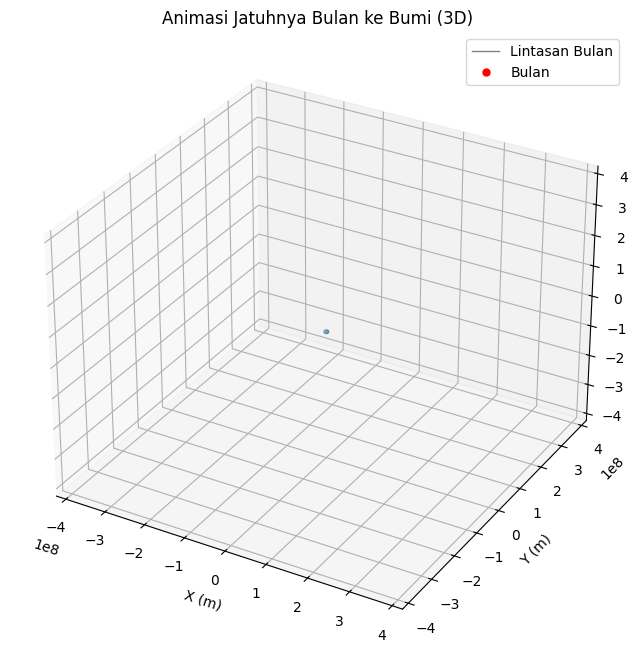


--- Selesai ---
Lanjut kerjakan laporan !


In [25]:
# Membuat dan Menampilkan Animasi 3D

print("\nMembuat dan menampilkan animasi 3D...")

fig_anim_3d = plt.figure(figsize=(10, 8))
ax_anim_3d = fig_anim_3d.add_subplot(111, projection='3d')

ax_anim_3d.plot_surface(x_earth_surf, y_earth_surf, z_earth_surf, color='deepskyblue', alpha=0.3, zorder=1)

line_anim, = ax_anim_3d.plot([], [], [], lw=1, color='grey', label='Lintasan Bulan', zorder=2)
point_anim, = ax_anim_3d.plot([], [], [], 'o', color='red', markersize=5, label='Bulan', zorder=3)

ax_anim_3d.set_xlim([-max_range, max_range])
ax_anim_3d.set_ylim([-max_range, max_range])
ax_anim_3d.set_zlim([-max_range, max_range])
ax_anim_3d.set_xlabel("X (m)")
ax_anim_3d.set_ylabel("Y (m)")
ax_anim_3d.set_zlabel("Z (m)")
ax_anim_3d.set_title("Animasi Jatuhnya Bulan ke Bumi (3D)")
ax_anim_3d.legend(loc='upper right')

time_text_anim = ax_anim_3d.text2D(0.05, 0.95, '', transform=ax_anim_3d.transAxes)

# Ini adalah baris KUNCI untuk memastikan animasi tetap hidup di lingkungan interaktif
# Variabel 'ani_3d' HARUS tetap ada di cakupan global.
ani_3d = animation.FuncAnimation(fig_anim_3d, animate_3d, frames=effective_num_frames,
                               init_func=init_anim_3d, blit=False, interval=50)

print("Animasi 3D akan ditampilkan. Ini mungkin butuh beberapa saat untuk render.")
plt.show() # Ini akan memblokir eksekusi sampai Anda menutup jendela animasi

print("\n--- Selesai ---")
print("Lanjut kerjakan laporan !")